# Data Wrangling

#### Project Overview
The goal of this project is to create a model that can predict whether or not a drug review will have a good rating, based on the review text.

#### Data Overview
| Column Name     | Column Description                          | 
| :---            | :---                                        |
| reviewID        | Unique review ID                            |
| drugName        | Name of drug being reviewed                 |
| condition       | Condition drug was used for                 |
| review          | Review text                                 |
| rating          | Rating from 1 to 10                         |
| date            | Date of review                              |
| usefulCount     | Number of times the review was voted useful |

#### Data Wrangling Goals
In this first step, data wrangling, my goals are to :
1. Import and preview data, convert data types if needed
3. Check for nulls and decide whether to drop or impute
3. Gain a general understanding of values and context
4. Clean and preprocess review text

## 1. Import

In [3]:
# data manipulation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
sns.set_palette('muted')

# nlp
import re
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

# data import/export
import pickle
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz

In [7]:
# import data and preview first 5 lines
reviews_df = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')
reviews_df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


I can already see there's some html code in the review text. A step will be included in my text cleaning function to remove this. The first column imported as "Unnamed: 0" because this was the index for the original data. I prefer a zero-based index here that wasn't based on the review ID so I'll update this column name to "reviewID."

In [8]:
# update first column name to 'reviewID'
name_map = {'Unnamed: 0': 'reviewID'}
reviews_df.rename(name_map, axis=1, inplace=True)

In [9]:
# view columns, data types, and possible nulls
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   reviewID     161297 non-null  int64  
 1   drugName     161297 non-null  object 
 2   condition    160398 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


Looks like Condition is the only columns with nulls.

Rating has a data type of float. I'm going to change that to integer since the rating scale is 1 to 10. 

With our goal being to build a model that predicts off the review text alone, I won't be using the review date as a feature. However, I'm curious to see whether the review date has any impact on ratings so I'll update this column to datetime.

In [10]:
# convert rating from float to int
reviews_df['rating'] = reviews_df['rating'].astype('int')

# convert date from object to datetime
reviews_df['date'] = pd.to_datetime(reviews_df['date'])

## 2. Nulls

In [23]:
# calculate count and percentage of nulls
null_counts = reviews_df.isnull().sum()
null_pcts = round(null_counts / len(reviews_df)*100, 2)

# create dataframe of null counts and percentages
null_counts_pcts = pd.concat([null_count, null_pct], axis=1, keys=['Count', 'Percent'])
display(null_counts_pcts)

,Count,Percent
reviewID,0,0.00
drugName,0,0.00
condition,899,0.56
review,0,0.00
rating,0,0.00
date,0,0.00
usefulCount,0,0.00


Less than 1% of the condition column is null. I could drop these, but I'd prefer not to lose any data. I'm going to fill the missing conditions with "NoCondition."

In [26]:
# replace condition nulls with NoCondition
reviews_df['condition'].fillna('NoCondition', inplace=True)

## 3. Context
### 3a. Condition and Drug Name
I want to look at condition and drug name, get a general idea of the values they contain, and check for any obvious data errors.

In [27]:
# count the number of unique drug names
num_unique_drugs = len(reviews_df['drugName'].unique())
print(f"Number of unique drug names: {num_unique_drugs}")

# view the 10 most common drug names
drug_name_top10 = reviews_df['drugName'].value_counts().index[:10]
print(f"\n10 most common drugs names: \n{pd.DataFrame(drug_name_top10)}")

Number of unique drug names: 3436

10 most common drugs names: 
                                    0
0                      Levonorgestrel
1                        Etonogestrel
2   Ethinyl estradiol / norethindrone
3                           Nexplanon
4    Ethinyl estradiol / norgestimate
5  Ethinyl estradiol / levonorgestrel
6                         Phentermine
7                          Sertraline
8                        Escitalopram
9                              Mirena


In [28]:
# preview all drug names
#sorted(reviews_df['drugName'].unique())

I also sorted all unique drug names and quickly scrolled through them. There weren't any obvious data issues.

In [29]:
# count the number of unique conditions
num_unique_conditions = len(reviews_df['condition'].unique())
print(f"Number of unique conditions: {num_unique_conditions}")

# view the 10 most common conditions
condition_top10 = reviews_df['condition'].value_counts().index[:10]
print(f"\n10 most common conditions: \n{pd.DataFrame(condition_top10)}")

Number of unique conditions: 885

10 most common conditions: 
                 0
0    Birth Control
1       Depression
2             Pain
3          Anxiety
4             Acne
5  Bipolar Disorde
6         Insomnia
7      Weight Loss
8          Obesity
9             ADHD


In [106]:
# preview all conditions
#reviews_df['condition'].unique()

I scrolled quickly through all conditions and noticed some conditions have a comment about the usefulness count rather than the actual condition (e.g. 2</span> users found this comment helpful). I'll want to replace these conditions, let's see how many of them there are.

In [30]:
# filter rows where the condition is a usefulness count
condition_is_comment = reviews_df[reviews_df['condition'].str.contains('users found this comment helpful')]

# calculate number of condition values that are actually usefulness counts
condition_is_comment_count = len(condition_is_comment)
print(f'Number of condition values as usefulness comment: {condition_is_comment_count}')

# calculate percentage of condition values that are usefulness counts
condition_is_comment_pct = condition_is_comment_count / len(reviews_df['condition']) * 100
print(f'Percentage of condition values that are usefulness comments: {condition_is_comment_pct:.2f}%')

Number of condition values as usefulness comment: 900
Percentage of condition values that are usefulness comments: 0.56%


Less than 1% of condition values are usefulness comments rather than actual conditions. I'll fill these instances with "NoCondition" as well.

In [31]:
# replace condition values with usefulness comments as NoCondition
condition_mask = reviews_df['condition'].str.contains('users found this comment helpful')
reviews_df[condition_mask]['condition'].replace('NoCondition', inplace=True)

### 3b. Review Length

I want to see if there's a relationship between the length of a review and the rating provided. In order to look at this later I'm going to calculate the word length for each review before I clean and preprocess the text.

In [35]:
# calculate character count
reviews_df['char_count'] = reviews_df['review'].str.len()

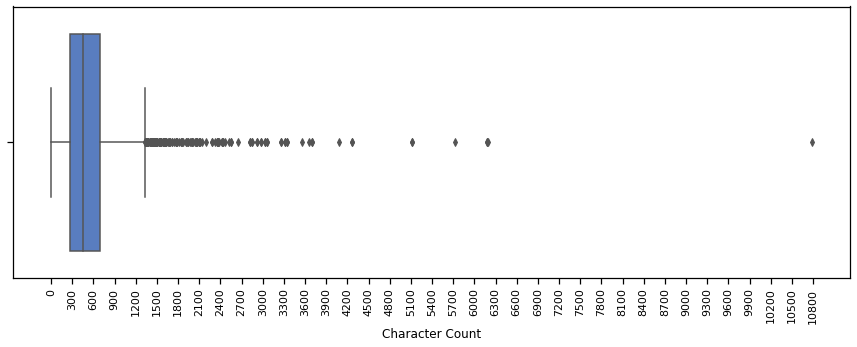

Character count median:  455.0


In [36]:
# view boxplot of character count
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(reviews_df['char_count'])
plt.xlabel('Character Count', fontsize=12)
plt.xticks(np.arange(0, 11000, 300), rotation=90)
plt.show()

print('Character count median: ', np.median(reviews_df['char_count']))

The boxplot shows there are a lot of outliers for character count, but most reviews have a character count near the median of 455 characters. I'm curious to see whether there will be a relationship between character count and rating. I'll be looking specifically at statistical relationships in a later step of this project.

### 3c. Review Context

To understand the general context of reviews in each rating and which ratings tend to be positive or negative, I want to sample some reviews for each rating.

In [37]:
# create range for rating values
rating_range = np.arange(1,11,1)

# display 5 reviews for each rating value
for rate in rating_range:
    display(reviews_df[reviews_df.rating == rate].head())

,reviewID,drugName,condition,review,rating,date,usefulCount,char_count
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,2017-03-07,5,142
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,2016-08-09,11,193
24,213649,Tioconazole,Vaginal Yeast Infection,"""Do not use the cream that comes with this. It...",1,2017-04-17,7,180
33,214453,Tioconazole,Vaginal Yeast Infection,"""The burning is out of control about 20 minute...",1,2015-09-11,2,130
36,125343,Dulcolax,Constipation,"""SO MUCH PAIN! \r\nIn the last 2 years I have ...",1,2016-02-13,10,400


,reviewID,drugName,condition,review,rating,date,usefulCount,char_count
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,2015-11-28,43,403
38,60678,MoviPrep,Bowel Preparation,"""I have taken this at least 5-6 times for the ...",2,2017-06-29,0,764
59,106703,Implanon,Birth Control,"""Never again! After being on depo I was suppos...",2,2015-08-20,1,478
68,202903,Gildess Fe 1 / 20,Birth Control,"""it caused me to gain 30 pounds""",2,2016-09-21,2,32
77,9116,Lo Loestrin Fe,Birth Control,"""I am always bleeding between periods, I&rsquo...",2,2017-10-26,5,536


,reviewID,drugName,condition,review,rating,date,usefulCount,char_count
14,98494,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,2014-08-07,10,786
61,192806,Drospirenone / ethinyl estradiol,Birth Control,"""I was put on Yasmin for 6 months to regulate ...",3,2011-04-11,8,491
90,43085,Sronyx,Birth Control,"""This medicine is absolutely terrible. After t...",3,2016-04-28,3,261
105,220696,Loestrin 24 Fe,2</span> users found this comment helpful.,"""I&#039;m 16 and I have been on Loestrin 24 f...",3,2010-11-03,2,718
123,144777,Etonogestrel,Birth Control,"""I was put on this birth control when I was 15...",3,2016-01-27,0,275


,reviewID,drugName,condition,review,rating,date,usefulCount,char_count
12,191290,Pentasa,Crohn's Disease,"""I had Crohn&#039;s with a resection 30 years ...",4,2013-07-06,8,403
13,221320,Dextromethorphan,Cough,"""Have a little bit of a lingering cough from a...",4,2017-09-07,1,591
44,121333,Venlafaxine,Depression,"""my gp started me on Venlafaxine yesterday to ...",4,2016-04-27,3,711
48,146502,Tamsulosin,Overactive Bladde,"""24 Year Old, Male, UK ,Normally I would go ev...",4,2017-01-03,10,589
81,171349,Wellbutrin,Depression,"""Started taking it and I slept well at night a...",4,2017-01-13,15,561


,reviewID,drugName,condition,review,rating,date,usefulCount,char_count
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,755
43,12056,Metaxalone,Muscle Spasm,"""I have been taking this medicine due to lower...",5,2014-06-04,55,137
64,60156,NuvaRing,Birth Control,"""I was off birth control for a while consideri...",5,2013-04-18,9,624
97,60280,NuvaRing,Birth Control,"""I am torn by the Nuvaring. The convenience is...",5,2011-10-31,0,753
147,59033,Morphine,Chronic Pain,"""I have been a long term sufferer of chronic p...",5,2016-06-08,54,739


,reviewID,drugName,condition,review,rating,date,usefulCount,char_count
28,132258,Ativan,Panic Disorde,"""Honestly, I have been taking ativan for 2 yea...",6,2015-06-01,47,499
60,131704,Effexor XR,Anxiety,"""Was on this med for 5 years. Worked fine but ...",6,2016-12-27,23,333
75,109866,Nexplanon,Birth Control,"""I&#039;ve had mine for over a year and notice...",6,2016-06-19,1,324
131,118141,Naltrexone,Opiate Dependence,"""I&#039;m Planning to be put in 17 Days in re...",6,2017-07-16,14,794
133,198581,Depo-Provera,Birth Control,"""Decreased my sex drive and physically in a lo...",6,2017-11-13,1,136


,reviewID,drugName,condition,review,rating,date,usefulCount,char_count
25,51215,Azithromycin,Chlamydia Infection,"""Was prescribed one dose over the course of on...",7,2015-12-14,7,403
49,153093,Doxycycline,Urinary Tract Infection,"""I battled a nasty UTI for over a month &amp; ...",7,2016-07-06,44,247
80,217014,Oxcarbazepine,Trigeminal Neuralgia,"""66 YO caucasian, male. Developed MS @22-23, d...",7,2016-07-18,15,736
82,60050,NuvaRing,Birth Control,"""I have been on pills for years, and in 2012 I...",7,2014-04-03,9,399
109,137538,Isotretinoin,Acne,"""I just started this medication on April 1st a...",7,2009-04-06,10,281


,reviewID,drugName,condition,review,rating,date,usefulCount,char_count
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,741
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,448
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,2016-12-08,1,737
20,12372,Atripla,HIV Infection,"""Spring of 2008 I was hospitalized with pnuemo...",8,2010-07-09,11,524
29,27339,Imitrex,Migraine,"""At first I suffered through them. This includ...",8,2012-10-16,6,746


,reviewID,drugName,condition,review,rating,date,usefulCount,char_count
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,79
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,719
10,29607,Topiramate,Migraine Prevention,"""I have been on this medication almost two wee...",9,2015-01-01,19,730
15,81890,Liraglutide,Obesity,"""I have been taking Saxenda since July 2016. ...",9,2017-01-19,20,733
16,48188,Trimethoprim,Urinary Tract Infection,"""This drug worked very well for me and cleared...",9,2017-09-22,0,676


,reviewID,drugName,condition,review,rating,date,usefulCount,char_count
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,2015-03-14,32,733
11,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,2017-03-09,54,460
18,212077,Lamotrigine,Bipolar Disorde,"""I&#039;ve been on every medicine under the su...",10,2014-11-09,18,770
19,119705,Nilotinib,Chronic Myelogenous Leukemia,"""I have been on Tasigna for just over 3 years ...",10,2015-09-01,11,480
21,231466,Trazodone,Insomnia,"""I have insomnia, it&#039;s horrible. My story...",10,2016-04-03,43,757


## 4. Clean & Preprocess Review Text

In [38]:
def clean_text(text):
    '''Function to clean and preprocess
       review text.'''
    # remove html
    text = BeautifulSoup(text, 'lxml').get_text()
    text = text.replace('\r\n', '')
    # make lower case
    text = text.lower()
    # tokenize and remove punctuation
    text = [word.strip(string.punctuation) for word in text.split(' ')]
    # remove non-alphabetic characters
    text = [word for word in text if word.isalpha()]
    # remove stop words
    stop = (stopwords.words('english'))
    text = [word for word in text if word not in stop]
    # stem words
    stemmer = PorterStemmer()
    text = [stemmer.stem(word) for word in text]
    return ' '.join(text)

In [39]:
# apply clean_text to review text
reviews_df['clean_review'] = reviews_df['review'].map(lambda x: clean_text(x))
reviews_df.head()

,reviewID,drugName,condition,review,rating,date,usefulCount,char_count,clean_review
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,79,side effect take combin bystol mg fish oil
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,741,son halfway fourth week intuniv becam concern ...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,755,use take anoth oral contracept pill cycl happi...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,448,first time use form birth control glad went pa...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,719,suboxon complet turn life around feel healthie...


In [40]:
# pickle dataframe
reviews_df.to_pickle('drugreviews_df')
reviews_df = pd.read_pickle('drugreviews_df')

### Convert to Document-Term Matrix

In [41]:
# initialize count vectorizer
vectorizer = CountVectorizer(ngram_range=(1,1),
                             min_df=0.05, max_df=0.90)

# create term matrix
vectorized = vectorizer.fit_transform(reviews_df['clean_review'])

# convert term matrix to dataframe
term_matrix = pd.DataFrame(vectorized.toarray(),
                           columns=vectorizer.get_feature_names(),
                           index=reviews_df['clean_review'].index)

# preview first 5 rows
term_matrix.head()

,abl,acn,ago,almost,also,alway,anxieti,around,away,back,...,week,weight,well,went,within,without,work,wors,would,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [95]:
# add ratings to term matrix
term_matrix['rating'] = reviews_df['rating']

# extract term matrix columns
term_matrix_cols = term_matrix.columns

# pickle term matrix columns
pickle_out = open('list.pickle', 'wb')
pickle.dump(term_matrix_cols, pickle_out)
pickle_out.close()

# save sparse matrix as npz
ngram_csr = csr_matrix(term_matrix)
save_npz('ngram_csr.npz', ngram_csr)